# Model Evaluation and Refinement

Now that we have built models and predicted car prices, we will determine how accurate these predictions are. 

Model evaluation tells us how our model performs in real world. In-sample evaluation tells us how well our model fits the data used to train it, but does not give any estimate of how well the trained model predicts new data. The solution is to split the data: use in-sample data or training data to train the model, and use rest of the data (test data) as out-of-sample data to approximate how the trained model works in the real world.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

from IPython.display import display
from IPython.html import widgets 
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual

pd.set_option('display.max_columns', None)

/opt/anaconda3/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
df = pd.read_csv('usedCarsDataClean.csv')
df.shape

(201, 30)

In [3]:
df['highway-mpg'] = 235/df['highway-L/100km']  # add the higway-mpg column

In [4]:
df = df._get_numeric_data()                    # get the numeric data only

In [5]:
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-L/100km,price,city-L/100km,diesel,gas,aspiration-std,aspiration-turbo,highway-mpg
0,3,122,88.6,-0.438315,0.890278,0.816054,2548,130,3.47,2.68,9.0,111.0,5000.0,21,8.703704,13495.0,11.190476,0,1,1,0,27.0
1,3,122,88.6,-0.438315,0.890278,0.816054,2548,130,3.47,2.68,9.0,111.0,5000.0,21,8.703704,16500.0,11.190476,0,1,1,0,27.0
2,1,122,94.5,-0.243544,0.909722,0.876254,2823,152,2.68,3.47,9.0,154.0,5000.0,19,9.038462,16500.0,12.368421,0,1,1,0,26.0
3,2,164,99.8,0.194690,0.919444,0.908027,2337,109,3.19,3.40,10.0,102.0,5500.0,24,7.833333,13950.0,9.791667,0,1,1,0,30.0
4,2,164,99.4,0.194690,0.922222,0.908027,2824,136,3.19,3.40,8.0,115.0,5500.0,18,10.681818,17450.0,13.055556,0,1,1,0,22.0


### Functions for Plotting

Let's define two functions for visualizations purpose

In [6]:
def distribution_plot(red_function, blue_function, red_name, blue_name, title ):
    
    plt.figure(figsize = (6,4))

    ax1 = sns.distplot(red_function, hist = False, color = "r", label = red_name)
    ax2 = sns.distplot(blue_function, hist = False, color = "b", label = blue_name, ax = ax1)

    plt.title(title)
    plt.xlabel('Price (in dollars)')
    plt.ylabel('Proportion of Cars')

    plt.show()
    plt.close()

In [7]:
def plot_poly(x_train, x_test, y_train, y_test, lr, poly_transform):
    
    plt.figure(figsize = (6,4))
 
    xmax = max([x_train.values.max(), x_test.values.max()])
    xmin = min([x_train.values.min(), x_test.values.min()])
    x = np.arange(xmin, xmax, 0.1)

    plt.plot(x_train, y_train, 'ro', label = 'Training Data')
    plt.plot(x_test, y_test, 'go', label =' Test Data')
    plt.plot(x, lr.predict(poly_transform.fit_transform(x.reshape(-1,1))), label = 'Predicted Function')
    
    plt.ylim([-10000,60000])
    plt.ylabel('Price')
    plt.legend()

## 1. Training and Testing

Splitting data into training and testing set is an important part of model evaluation. When splitting a dataset, usually the larger portion of data is used for training and a smaller part is used for testing. We use training set to build the model and discover predictive relationships. We then use the testing set to evaluate model performance, to give an idea how our model will perform in real world. Once we have completed testing our model, we should use all the data to train the model to get the best performance.

In [8]:
y_data = df['price']                     # placing the 'price' in a separate dataframe y_data
x_data = df.drop('price', axis = 1)      # drop 'price' data in x_data dataframe

Now we randomly split our data into training and testing set using the function train_test_split(). The x_data and y_data provided to the train_test_split function are feature-variables and target variable respectively.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15, random_state = 1)

print("number of test samples :", x_test.shape[0])
print("number of training samples:", x_train.shape[0])

number of test samples : 31
number of training samples: 170


Here, we split our dataset (x_data, y_data) into training set (x_train, y_train) and test set (x_test, y_test). The test_size parameter sets the proportion of data that is split into the testing set.

In [10]:
lre = LinearRegression()                              # create a linear regression object
lre.fit(x_train[['horsepower']], y_train)             # fit the model using the feature horsepower

print(lre.score(x_train[['horsepower']], y_train))    # calculate R-squared for the training data
print(lre.score(x_test[['horsepower']], y_test))      # calculate R-squared for the test data

0.6449517437659684
0.707688374146705


### Cross-validation Score

Generalization error is a meaure of how well our model does at predicting previously unseen data. We can treat our testing data as unseen data. The error we obtain using our testing data is an approximation of generalization error. 

One of the most common out-of-sample evaluation metric is cross-validation. In this method, the dataset is split into k equal groups. Each group is referred to as a fold. One fold is used for testing and the remaining ones are for training. For example, in a four fold split, we use three folds for training and one fold for testing. This is repeated until each fold is used for both training and testing. In the end, we use the average result as the estimate of out-of-sample error. 

We use cross_val_score() to apply cross-validation, which performs multiple out-of-sample evaluation. The default scoring (evaluation) is R-squared.

We input the model (linear regression object here), the feature (horsepower), the target (price). Parameter cv is  the number of folds (in this case 4)

In [11]:
r2_cross = cross_val_score(lre, x_data[['horsepower']], y_data, cv = 4)
print(r2_cross)
print("The mean of the folds are", r2_cross.mean(),"and the standard deviation is" , r2_cross.std())

[0.7746232  0.51716687 0.74785353 0.04839605]
The mean of the folds are 0.522009915042119 and the standard deviation is 0.2911839444756029


This function returns an array of scores, one for each partition that was chosen as the testing set. 

Lets explain this in a little detail. Here, we are using 4 folds. Now, we use three folds for training the model and one fold for testing. r2_cross gives R-sqaured measured on this test set, with the model obtained from the training on three other folds. This process is repeated for all four folds. 

Note: We just need to declare lre object, and then pass it to cross_val_score() function. This function does the training and testing both

Instead of the default R-squared, we can use negative squared error as a score by setting the parameter  'scoring' metric to 'neg_mean_squared_error':

In [12]:
nmse = -1*cross_val_score(lre, x_data[['horsepower']], y_data, cv = 4, scoring = 'neg_mean_squared_error')
print(nmse)

[20254142.84026704 43745493.2650517  12539630.34014931 17561927.72247591]


The cross_val_score() function returns the score value to tell us the cross-validation result. Similar to cross_val_score(), we can use cross_val_predict() function to predict the output. It works exactly as in the case of cross_val_score(), except that instead of returning a score, it returns a prediction on the test set. The other folds are used to train the model as in the case of cross_val_score().

In [13]:
yhat = cross_val_predict(lre, x_data[['horsepower']], y_data, cv = 4)
print(len(yhat))
print(yhat[:10])

201
[14141.63807508 14141.63807508 20814.29423473 12745.03562306
 14762.35027598 13986.46002486 13986.46002486 13986.46002486
 18641.80153159 12589.85757284]


## 2. Overfitting, Underfitting and Model Selection

It turns out that the test data sometimes referred to as the out of sample data is a much better measure of how well the model performs in the real world.
<br>One reason for this is overfitting. This is more apparent in Multiple Linear Regression and Polynomial Regression so we will explore overfitting in that context.

Lets understand underfitting and overfitting: Suppose we have a data scattered around a parabolic line (y ~ x^2) with some noise, and we want to fit this data using polynomial regression. The goal of model selection is to determine the order of the polynomial to provide the best estimate of the parabolic data. If we fit this data with degree one polynomial (line), it can never capture the parabolic behaviour. This situation is known as underfitting, where the model is too simple to fit the data. In contrast, if we take a higher order polynomial, say 6, the model is too flexible and even fit the noise and will not capture the simple parabolic behaviour. This particular situation is known as overfitting.

First, lets try Multiple Linear Regression: let's train the model using horsepower, curb-weight, engine-size, and highway-mpg as features

In [14]:
lr_multi = LinearRegression()
lr_multi.fit(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Prediction using training data

In [15]:
yhat_train = lr_multi.predict(x_train[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_train[0:5]

array([11927.70699817, 11236.71672034,  6436.91775515, 21890.22064982,
       16667.18254832])

Prediction using test data

In [16]:
yhat_test = lr_multi.predict(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']])
yhat_test[0:5]

array([11349.16502418,  5914.48335385, 11243.76325987,  6662.03197043,
       15555.76936275])

Let's perform some model evaluation using our training and testing data separately. First, lets compare the distribution of the predicted values with the actual values of the training data.

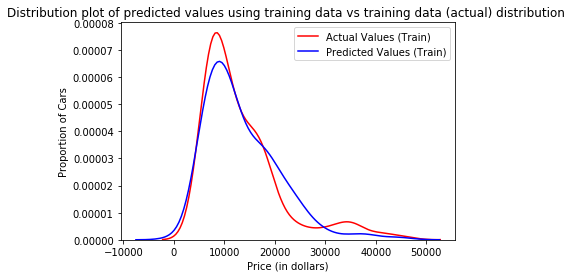

In [17]:
title = 'Distribution plot of predicted values using training data vs training data (actual) distribution '
distribution_plot(y_train, yhat_train, "Actual Values (Train)", "Predicted Values (Train)", title)

The model seems to be doing well in learning from the training dataset. What happens when the trained model encounters new data from the testing dataset ?  

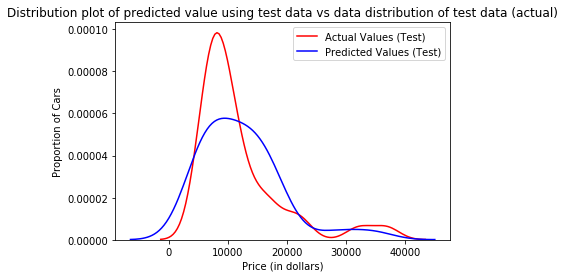

In [18]:
title = 'Distribution plot of predicted value using test data vs data distribution of test data (actual)'
distribution_plot(y_test, yhat_test, "Actual Values (Test)", "Predicted Values (Test)", title)

When the trained model generates new values from the test data, the distribution of the predicted values is much different from the actual target values.

**Overfitting :** Overfitting occurs when the model fits the noise, not the underlying process. Therefore when testing the model using the test-set, the model does not perform as well, as it is modelling noise, not the underlying process that generated the relationship. 

Let's see if polynomial regression also exhibits a drop in the prediction accuracy when analysing the test dataset.

Let's use 45 percent of the data for testing and the rest for training, and fit a degree 5 polynomial model. We will perform a degree 5 polynomial transformation on the feature 'horse power'.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.45, random_state = 0)

pr = PolynomialFeatures(degree = 5)
x_train_pr = pr.fit_transform(x_train[['horsepower']])
x_test_pr = pr.fit_transform(x_test[['horsepower']])

poly = LinearRegression()                   # create a linear regression model poly
poly.fit(x_train_pr, y_train)               # train the model using training data

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's use the above defined function to display the training data, testing data, and the predicted function:

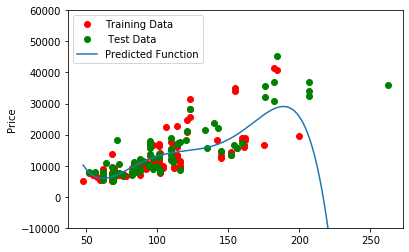

In [20]:
plot_poly(x_train[['horsepower']], x_test[['horsepower']], y_train, y_test, poly, pr)

We see that the estimated function appears to track the data but at around 200 horsepower, the function begins to diverge from the data points. 

In [21]:
print(poly.score(x_train_pr, y_train))           # R-squared of the training data
print(poly.score(x_test_pr, y_test))             # R-squared of the test data

0.5567716902635091
-29.87141885918752


R^2 for the training data is 0.5567, while it is -29.87 for the test data. The lower the R^2, the worse the model. Now, let's see how the R^2 changes on the test data for different order polynomials and plot the results.

Text(3, 0.75, 'Maximum R^2 ')

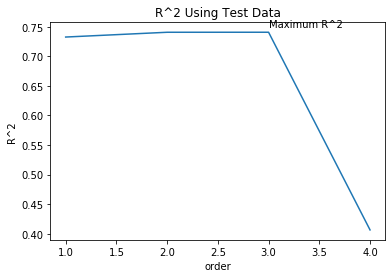

In [23]:
Rsq_test = []

order = [1, 2, 3, 4]

lr_poly = LinearRegression()

for n in order:
    pr = PolynomialFeatures(degree = n)
    x_train_pr = pr.fit_transform(x_train[['horsepower']])
    x_test_pr = pr.fit_transform(x_test[['horsepower']])
    lr_poly.fit(x_train_pr, y_train)
    Rsq_test.append(lr_poly.score(x_test_pr, y_test))

plt.plot(order, Rsq_test)
plt.xlabel('order')
plt.ylabel('R^2')
plt.title('R^2 Using Test Data')
plt.text(3, 0.75, 'Maximum R^2 ')   

We see that R^2 gradually increases until an order three polynomial is used, then it dramatically decreases at four.

## 3. Ridge Regression

Ridge regression prevents overfitting. Lets understand in detail how we can avoid overfitting using ridge regression. 

Consider a data which can be best fitted by fourth order polynomial. In many cases, real data have outliers. So, if we fit the data by a 10th order polynomial, it will overfit and model the outliers even. If we look at the expression for the estimated function, we see that the coefficients of higher order terms in the estimated polynomial have very large magnitudes. Ridge regression controls the magnitude of these polynomial coefficients by introducing the parameter Alfa. 

We select Alfa before training the model. We use alpha to reduce the magnitude of the coefficients of higher order terms. When Alfa = 0, there is no reduction in the magnitude and we get overfitting. When Alfa = infinity, even lower order terms are made insignificant and we get underfitting. Thus, Alfa should be chosen judiciously, just large enough so that it reduces the coefficients of higher order terms causing overfitting. We use cross-validation to select Alfa.

We illustrated overfitting in the case of polynomial regression, but it also occurs when using multiple linear regression with many independent features.

Let's perform a degree two polynomial transformation on our data:

In [24]:
features = ['horsepower', 'curb-weight', 'engine-size', 'highway-mpg','normalized-losses','symboling']

pr = PolynomialFeatures(degree = 2)
x_train_pr = pr.fit_transform(x_train[features])
x_test_pr = pr.fit_transform(x_test[features])

In [25]:
RidgeModel = Ridge(alpha = 0.1)    # ridge regression object, with regularization parameter 0.1
RidgeModel.fit(x_train_pr, y_train)
yhat = RidgeModel.predict(x_test_pr)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.02972e-16): result may not be accurate.
  overwrite_a=True).T


We select the value of Alfa as follows: First, we choose a value of Alfa, train the model with this value of Alfa, and then make a prediction on the validation data (validation data is similar to test data but it is used to select parameters such as Alfa) and measure the value of R-squared. We do this over a range of values of Alfa and select the Alfa which minimizes the error on the validation data. Note that here, we will be using our test data as validation data, and we can use other metric like MSE to select alpha.

In [27]:
Rsq_train = []
Rsq_test = []
dummy1 = []
ALFA = 5000*np.array(range(0,10000))

for alfa in ALFA:
    RidgeModel = Ridge(alpha = alfa)
    RidgeModel.fit(x_train_pr, y_train)
    Rsq_train.append(RidgeModel.score(x_train_pr, y_train))
    Rsq_test.append(RidgeModel.score(x_test_pr, y_test)) 

Let's plot R^2 vs Alpha

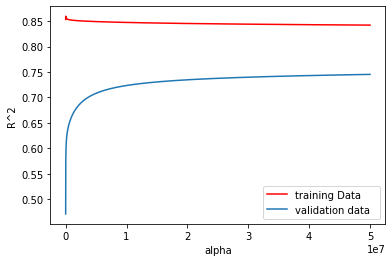

In [28]:
plt.figure(figsize = (6,4))
plt.plot(ALFA, Rsq_train, 'r', label = 'training Data ')
plt.plot(ALFA, Rsq_test, label = 'validation data  ')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.legend()

We see that as the value of alpha increases, R-squared on the validation data increases and converges approximately at 0.75. In this case, we select the maximum value of Alfa, because using the higher values of alpha have little impact. Conversely, as Alfa increases, R-squared on the training data decreases. This is because higher values of Alfa prevent overfitting. 

##  4. Grid Search

Grid search allows us to scan through multiple free parameters efficiently. Alfa is a hyperparameter, a parameter which is not part of fitting or training process. Scikit-learn has a class GridSearchCV, to automatically iterate over such hyperparameters using cross-validation.

Grid search takes the model or object we want to train and different values of the hyperparameters. To select the hyperparameters, we split our dataset into three parts: training set, validation set and test set. We train the model for different hyperparameters using the training set. We select the hyperparameters that minimizes the MSE or maximizes the R-squared on the validation set. We finally test our model performance using the test data.

In [30]:
parameters= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000]}]

RR = Ridge()                                  # create a ridge regression object/model
Grid = GridSearchCV(RR, parameters, cv = 4)   # create a ridge grid search object
Grid.fit(x_data[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_data)   # fit the model
BestRR = Grid.best_estimator_      # returns the estimator with the best values of the free parameters

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


We now test our model (BestRR contains the model with best parameter values) on the test data:

In [31]:
BestRR.score(x_test[['horsepower', 'curb-weight', 'engine-size', 'highway-mpg']], y_test)

0.8411649831036149

The default scoring is R-squared. The mean score for each value of alpha can be obtained as:

In [33]:
scores = Grid.cv_results_
scores['mean_test_score']           # mean value of test score for each value of alpha

array([0.66548837, 0.66548894, 0.66549413, 0.66554568, 0.66602936,
       0.66896822, 0.67334636, 0.65781884, 0.65781884])

This mean is calculated as usual: As we are using cv = 4, three folds are used for training and one for cross-validation. The scores are calculated on cross-validation data, and finally averaged over all four folds. We can also obtain the scoring for all folds separately :

In [34]:
scores

{'mean_fit_time': array([0.00234526, 0.00180578, 0.0018847 , 0.00170571, 0.00166374,
        0.0017153 , 0.00159985, 0.00156182, 0.00164253]),
 'std_fit_time': array([1.72183067e-04, 2.25964534e-04, 2.90261671e-04, 1.31975115e-04,
        9.00869539e-05, 1.32525831e-04, 4.23024624e-05, 1.89444341e-05,
        1.24218639e-04]),
 'mean_score_time': array([0.00120187, 0.00099248, 0.00101769, 0.00105697, 0.00098997,
        0.00111496, 0.00098997, 0.00095642, 0.00095946]),
 'std_score_time': array([1.26842493e-04, 1.45634286e-05, 2.72311698e-05, 1.46485603e-04,
        3.54985069e-05, 1.46174750e-04, 3.76049573e-05, 7.63032580e-06,
        9.08399035e-06]),
 'param_alpha': masked_array(data=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000, 100000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.001},
  {'alpha': 0.1},
  {'alpha': 1},
  {'alpha': 10},
  {'alpha': 

In the above grid search, we search for only one parameter, hyperparameter alpha. The advantage of grid search is that how quickly we can test multiple parameters. For example, Ridge regression has the option 'normalize' 
to normalize the data,
We can think of the key 'normalize' as a paramater, in addition to alpha and pass it to GridSearchCV(). The key 'normalize' has two values True (normalize) and False (do not normalize).

In [35]:
parameters= [{'alpha': [0.001,0.1,1, 10, 100, 1000,10000,100000,100000], 'normalize':[True, False]}]

We can repeat the above code with these two parameters dictionary-list. Now the GridSearchCV will go through all combinations of these two parameters (0.001,True), (0.001, False), (0.1, True).....(100000, True), (100000, False) to find the best estimator.